In [1]:
import os
import findspark

os.environ['JAVA_HOME'] = r'C:\Program Files\Eclipse Adoptium\jdk-17.0.16.8-hotspot'
os.environ['PATH'] = os.environ['JAVA_HOME'] + r'\bin;' + os.environ['PATH']

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TestSparkNotebook").getOrCreate()
print("Spark version:", spark.version)

df = spark.range(5)
df.show()


Spark version: 4.0.0
+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [2]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: C:\Users\quine\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: C:\Users\quine\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [4]:
from pyspark.sql.functions import col, when, substring, concat_ws, to_date, to_timestamp, count, lit, sum as spark_sum, round
from pyspark.sql.types import StringType, DoubleType

# Collect Data

In [5]:
df = spark.read.csv(
    'Prestaciones de salud asociadas a los asegurados con Diabetes Mellitus.csv',
    header=True,
    inferSchema=True
)

In [6]:
display(df)

DataFrame[FECHA_CORTE: int, ULTIMO_MES_CONSUMOS: int, CODIGO_ANONIMIZADO: string, FECHA_NACIMIENTO: int, EDAD: int, SEXO: string, TIPO_DIABETES: string, FECHA_FALLECIMIENTO: int, UBIGEO: int, DEPARTAMENTO: string, PROVINCIA: string, DISTRITO: string, NIVEL_EESS: int, CODIGO_SERV_PRESTACIONAL: string, SERVICIO_PRESTACIONAL: string, DIAS_HOSP: int, ID_REGISTRO_REL: string, FECHA_ATENCION: int, TIPO_PERSONAL_SALUD: string, FECATE_POST_FECFED: string, CODDIA: string, C10_NOMBRE: string, TIPO_DIAGNOSTICO: string, TIPO_CONSUMO: string, CODIGO_CONSUMO: string, NOMBRE_CONSUMO: string, PRESENTACION_MEDICAMENTO: string, FORMA_FARMACEUTICA: string, CANTIDAD_ENTREGADA: int, VALOR_NETO: double]

In [7]:
df.count()

45666822

In [8]:
df.columns

['FECHA_CORTE',
 'ULTIMO_MES_CONSUMOS',
 'CODIGO_ANONIMIZADO',
 'FECHA_NACIMIENTO',
 'EDAD',
 'SEXO',
 'TIPO_DIABETES',
 'FECHA_FALLECIMIENTO',
 'UBIGEO',
 'DEPARTAMENTO',
 'PROVINCIA',
 'DISTRITO',
 'NIVEL_EESS',
 'CODIGO_SERV_PRESTACIONAL',
 'SERVICIO_PRESTACIONAL',
 'DIAS_HOSP',
 'ID_REGISTRO_REL',
 'FECHA_ATENCION',
 'TIPO_PERSONAL_SALUD',
 'FECATE_POST_FECFED',
 'CODDIA',
 'C10_NOMBRE',
 'TIPO_DIAGNOSTICO',
 'TIPO_CONSUMO',
 'CODIGO_CONSUMO',
 'NOMBRE_CONSUMO',
 'PRESENTACION_MEDICAMENTO',
 'FORMA_FARMACEUTICA',
 'CANTIDAD_ENTREGADA',
 'VALOR_NETO']

# Data Quality & Cleaning

### Data Type Mismatch

In [9]:
df.printSchema()

root
 |-- FECHA_CORTE: integer (nullable = true)
 |-- ULTIMO_MES_CONSUMOS: integer (nullable = true)
 |-- CODIGO_ANONIMIZADO: string (nullable = true)
 |-- FECHA_NACIMIENTO: integer (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- TIPO_DIABETES: string (nullable = true)
 |-- FECHA_FALLECIMIENTO: integer (nullable = true)
 |-- UBIGEO: integer (nullable = true)
 |-- DEPARTAMENTO: string (nullable = true)
 |-- PROVINCIA: string (nullable = true)
 |-- DISTRITO: string (nullable = true)
 |-- NIVEL_EESS: integer (nullable = true)
 |-- CODIGO_SERV_PRESTACIONAL: string (nullable = true)
 |-- SERVICIO_PRESTACIONAL: string (nullable = true)
 |-- DIAS_HOSP: integer (nullable = true)
 |-- ID_REGISTRO_REL: string (nullable = true)
 |-- FECHA_ATENCION: integer (nullable = true)
 |-- TIPO_PERSONAL_SALUD: string (nullable = true)
 |-- FECATE_POST_FECFED: string (nullable = true)
 |-- CODDIA: string (nullable = true)
 |-- C10_NOMBRE: string (nullable = tru

In [10]:
# Si tiene la palabra FECHA cambiar a String
for c in df.columns:
    if "FECHA" in c.upper():
        df = df.withColumn(c, col(c).cast(StringType()))

In [11]:
df.printSchema()

root
 |-- FECHA_CORTE: string (nullable = true)
 |-- ULTIMO_MES_CONSUMOS: integer (nullable = true)
 |-- CODIGO_ANONIMIZADO: string (nullable = true)
 |-- FECHA_NACIMIENTO: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- TIPO_DIABETES: string (nullable = true)
 |-- FECHA_FALLECIMIENTO: string (nullable = true)
 |-- UBIGEO: integer (nullable = true)
 |-- DEPARTAMENTO: string (nullable = true)
 |-- PROVINCIA: string (nullable = true)
 |-- DISTRITO: string (nullable = true)
 |-- NIVEL_EESS: integer (nullable = true)
 |-- CODIGO_SERV_PRESTACIONAL: string (nullable = true)
 |-- SERVICIO_PRESTACIONAL: string (nullable = true)
 |-- DIAS_HOSP: integer (nullable = true)
 |-- ID_REGISTRO_REL: string (nullable = true)
 |-- FECHA_ATENCION: string (nullable = true)
 |-- TIPO_PERSONAL_SALUD: string (nullable = true)
 |-- FECATE_POST_FECFED: string (nullable = true)
 |-- CODDIA: string (nullable = true)
 |-- C10_NOMBRE: string (nullable = true)
 

In [12]:
# Convertir las columnas de FECHA a formato DD/MM/YYYY (string)
for c in df.columns:
    if "FECHA" in c.upper():        
        df = df.withColumn(
            c,
            when(
                col(c).isNotNull() & (col(c) != ""),
                concat_ws(
                    "/",
                    substring(col(c), 7, 2),   # DD
                    substring(col(c), 5, 2),   # MM
                    substring(col(c), 1, 4)    # YYYY
                )
            ).otherwise(None))

In [13]:
# Convertir a tipo timestamp
for c in df.columns:
    if "FECHA" in c.upper():
        df = df.withColumn(
            c,
            to_timestamp(col(c), "dd/MM/yyyy")
        )

### Uniform Data

In [14]:
from pyspark.sql import functions as F

agg_exprs = [F.approx_count_distinct(c).alias(f"{c}_approx_unique") for c in df.columns]
unique_counts = df.agg(*agg_exprs).collect()[0].asDict()

for col, count in unique_counts.items():
    print(f"Columna: {col.replace('_approx_unique','')} | Valores únicos (approx): {count}")


Columna: FECHA_CORTE | Valores únicos (approx): 1
Columna: ULTIMO_MES_CONSUMOS | Valores únicos (approx): 1
Columna: CODIGO_ANONIMIZADO | Valores únicos (approx): 607025
Columna: FECHA_NACIMIENTO | Valores únicos (approx): 33456
Columna: EDAD | Valores únicos (approx): 114
Columna: SEXO | Valores únicos (approx): 2
Columna: TIPO_DIABETES | Valores únicos (approx): 6
Columna: FECHA_FALLECIMIENTO | Valores únicos (approx): 718
Columna: UBIGEO | Valores únicos (approx): 1909
Columna: DEPARTAMENTO | Valores únicos (approx): 24
Columna: PROVINCIA | Valores únicos (approx): 199
Columna: DISTRITO | Valores únicos (approx): 1758
Columna: NIVEL_EESS | Valores únicos (approx): 4
Columna: CODIGO_SERV_PRESTACIONAL | Valores únicos (approx): 55
Columna: SERVICIO_PRESTACIONAL | Valores únicos (approx): 60
Columna: DIAS_HOSP | Valores únicos (approx): 217
Columna: ID_REGISTRO_REL | Valores únicos (approx): 9662137
Columna: FECHA_ATENCION | Valores únicos (approx): 642
Columna: TIPO_PERSONAL_SALUD | V

In [15]:
# Eliminamos columnas con valores constantes
df = df.drop('FECHA_CORTE', 'ULTIMO_MES_CONSUMOS')

### Duplicated data

In [16]:
from pyspark.sql.functions import countDistinct

# Agrupar por CODIGO_SERV_PRESTACIONAL y contar los servicios distintos
duplicados = df.groupBy("CODIGO_SERV_PRESTACIONAL") \
    .agg(countDistinct("SERVICIO_PRESTACIONAL").alias("num_servicios")) \
    .filter("num_servicios > 1")

duplicados.count()

0

In [17]:
print(df.columns)


['CODIGO_ANONIMIZADO', 'FECHA_NACIMIENTO', 'EDAD', 'SEXO', 'TIPO_DIABETES', 'FECHA_FALLECIMIENTO', 'UBIGEO', 'DEPARTAMENTO', 'PROVINCIA', 'DISTRITO', 'NIVEL_EESS', 'CODIGO_SERV_PRESTACIONAL', 'SERVICIO_PRESTACIONAL', 'DIAS_HOSP', 'ID_REGISTRO_REL', 'FECHA_ATENCION', 'TIPO_PERSONAL_SALUD', 'FECATE_POST_FECFED', 'CODDIA', 'C10_NOMBRE', 'TIPO_DIAGNOSTICO', 'TIPO_CONSUMO', 'CODIGO_CONSUMO', 'NOMBRE_CONSUMO', 'PRESENTACION_MEDICAMENTO', 'FORMA_FARMACEUTICA', 'CANTIDAD_ENTREGADA', 'VALOR_NETO']


In [18]:
# Verificar códigos con múltiples nombres
duplicados_consumo = df.groupBy("CODIGO_CONSUMO") \
    .agg(countDistinct("NOMBRE_CONSUMO").alias("num_nombres")) \
    .filter("num_nombres > 1")


display(duplicados_consumo)

DataFrame[CODIGO_CONSUMO: string, num_nombres: bigint]

In [19]:
# Filtrar registros donde CODIGO_CONSUMO sea 29405
display(df.filter(df["CODIGO_CONSUMO"] == 29405))


DataFrame[CODIGO_ANONIMIZADO: string, FECHA_NACIMIENTO: timestamp, EDAD: int, SEXO: string, TIPO_DIABETES: string, FECHA_FALLECIMIENTO: timestamp, UBIGEO: int, DEPARTAMENTO: string, PROVINCIA: string, DISTRITO: string, NIVEL_EESS: int, CODIGO_SERV_PRESTACIONAL: string, SERVICIO_PRESTACIONAL: string, DIAS_HOSP: int, ID_REGISTRO_REL: string, FECHA_ATENCION: timestamp, TIPO_PERSONAL_SALUD: string, FECATE_POST_FECFED: string, CODDIA: string, C10_NOMBRE: string, TIPO_DIAGNOSTICO: string, TIPO_CONSUMO: string, CODIGO_CONSUMO: string, NOMBRE_CONSUMO: string, PRESENTACION_MEDICAMENTO: string, FORMA_FARMACEUTICA: string, CANTIDAD_ENTREGADA: int, VALOR_NETO: double]

In [20]:
df = df.withColumn("CLAVE_CONSUMO", concat_ws("_", "TIPO_CONSUMO", "CODIGO_CONSUMO"))

In [21]:
# Eliminamos columnas con valores constantes
df = df.drop('CODIGO_SERV_PRESTACIONAL')

### Missing Data

#### Filas

In [22]:
from pyspark.sql.functions import col, when, substring, concat_ws, to_date, to_timestamp, count, lit, sum as spark_sum, round

total_cols = len(df.columns)

# Calcular cantidad de nulos por fila
df_with_nulls = df.withColumn(
    "nulls_per_row",
    sum(
        when(col(c).isNull(), 1).otherwise(0)
        for c in df.columns
    )
)

df_with_nulls = df_with_nulls.withColumn(
    "porcentaje_nulls",
    round((col("nulls_per_row") / total_cols) * 100, 2)
)

df_with_nulls_ordered = df_with_nulls.orderBy(col("porcentaje_nulls").desc())

display(df_with_nulls_ordered)

DataFrame[CODIGO_ANONIMIZADO: string, FECHA_NACIMIENTO: timestamp, EDAD: int, SEXO: string, TIPO_DIABETES: string, FECHA_FALLECIMIENTO: timestamp, UBIGEO: int, DEPARTAMENTO: string, PROVINCIA: string, DISTRITO: string, NIVEL_EESS: int, SERVICIO_PRESTACIONAL: string, DIAS_HOSP: int, ID_REGISTRO_REL: string, FECHA_ATENCION: timestamp, TIPO_PERSONAL_SALUD: string, FECATE_POST_FECFED: string, CODDIA: string, C10_NOMBRE: string, TIPO_DIAGNOSTICO: string, TIPO_CONSUMO: string, CODIGO_CONSUMO: string, NOMBRE_CONSUMO: string, PRESENTACION_MEDICAMENTO: string, FORMA_FARMACEUTICA: string, CANTIDAD_ENTREGADA: int, VALOR_NETO: double, CLAVE_CONSUMO: string, nulls_per_row: int, porcentaje_nulls: double]

Se imputará el nulo en TIPO_PERSONAL_SALUD en el análisis de columnas nulas

#### Columnas

In [23]:
total_rows = df.count()

# Crear DataFrame con columna y cantidad de nulos
null_df = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])

null_counts = null_df.collect()[0].asDict()

# Crear DataFrame vertical con columnas, cantidad de nulos y %
null_summary = spark.createDataFrame([
    (col_name, null_counts[col_name], (null_counts[col_name] / total_rows) * 100)
    for col_name in df.columns
],
["columna", "cantidad_nulos", "porcentaje_nulos"]
)

null_summary = null_summary.orderBy(col("porcentaje_nulos").desc())

display(null_summary)

DataFrame[columna: string, cantidad_nulos: bigint, porcentaje_nulos: double]

In [24]:
# Unificar consumo en variable
from pyspark.sql.functions import col, concat_ws, when

df = df.withColumn(
    "CONSUMO_OFICIAL",
    when(
        col("NOMBRE_CONSUMO").isNull() & col("PRESENTACION_MEDICAMENTO").isNull(),
        None  # Retorna null si ambos son null
    ).otherwise(
        when(
            col("FORMA_FARMACEUTICA").isNotNull(),
            concat_ws(" ", col("NOMBRE_CONSUMO"), col("PRESENTACION_MEDICAMENTO"), col("FORMA_FARMACEUTICA"))
        ).otherwise(
            concat_ws(" ", col("NOMBRE_CONSUMO"), col("PRESENTACION_MEDICAMENTO"))
        )
    )
)

In [25]:
# Eliminamos columnas con >50% de valores nulos (considerando criterios)
df = df.drop('PRESENTACION_MEDICAMENTO', 'FORMA_FARMACEUTICA')

In [26]:
# Imputar valores TIPO_PERSONAL_SALUD
df = df.withColumn(
    "TIPO_PERSONAL_SALUD",
    when(col("TIPO_PERSONAL_SALUD").isNull(), lit("AUXILIAR DE ENFERMERIA")).otherwise(col("TIPO_PERSONAL_SALUD"))
)

In [27]:
# Imputar valores VALOR_NETO
df = df.withColumn(
    "CANTIDAD_ENTREGADA",
    when(col("CANTIDAD_ENTREGADA").isNull(), lit(0)).otherwise(col("CANTIDAD_ENTREGADA"))
)

In [28]:
# Imputar valores VALOR_NETO
df = df.withColumn(
    "VALOR_NETO",
    when(col("VALOR_NETO").isNull(), lit(0)).otherwise(col("VALOR_NETO"))
)

### Outliers

#### Numéricos

In [29]:
import builtins
columns_to_check = ["EDAD", "DIAS_HOSP", "CANTIDAD_ENTREGADA", "VALOR_NETO"]

total_rows = df.count()

for columna in columns_to_check:
 
    quantiles = df.approxQuantile(columna, [0.25, 0.75], 0.05)
    Q1, Q3 = quantiles
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar registros outliers
    outliers_df = df.filter(
        (col(columna) < lower_bound) | (col(columna) > upper_bound)
    )

    outliers_count = outliers_df.count()
    outliers_pct = builtins.round((outliers_count / total_rows) * 100, 2)

    print(f"  Columna: {columna}")
    print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"  Límite inferior: {lower_bound}, Límite superior: {upper_bound}")
    print(f"  Outliers detectados: {outliers_count} de {total_rows} registros ({outliers_pct}%)")
    print("-"*60)


  Columna: EDAD
  Q1: 48.0, Q3: 68.0, IQR: 20.0
  Límite inferior: 18.0, Límite superior: 98.0
  Outliers detectados: 918062 de 45666822 registros (2.01%)
------------------------------------------------------------
  Columna: DIAS_HOSP
  Q1: 0.0, Q3: 8.0, IQR: 8.0
  Límite inferior: -12.0, Límite superior: 20.0
  Outliers detectados: 1485983 de 45666822 registros (3.25%)
------------------------------------------------------------
  Columna: CANTIDAD_ENTREGADA
  Q1: 1.0, Q3: 4.0, IQR: 3.0
  Límite inferior: -3.5, Límite superior: 8.5
  Outliers detectados: 9397291 de 45666822 registros (20.58%)
------------------------------------------------------------
  Columna: VALOR_NETO
  Q1: 0.0, Q3: 4.34, IQR: 4.34
  Límite inferior: -6.51, Límite superior: 10.85
  Outliers detectados: 6236066 de 45666822 registros (13.66%)
------------------------------------------------------------


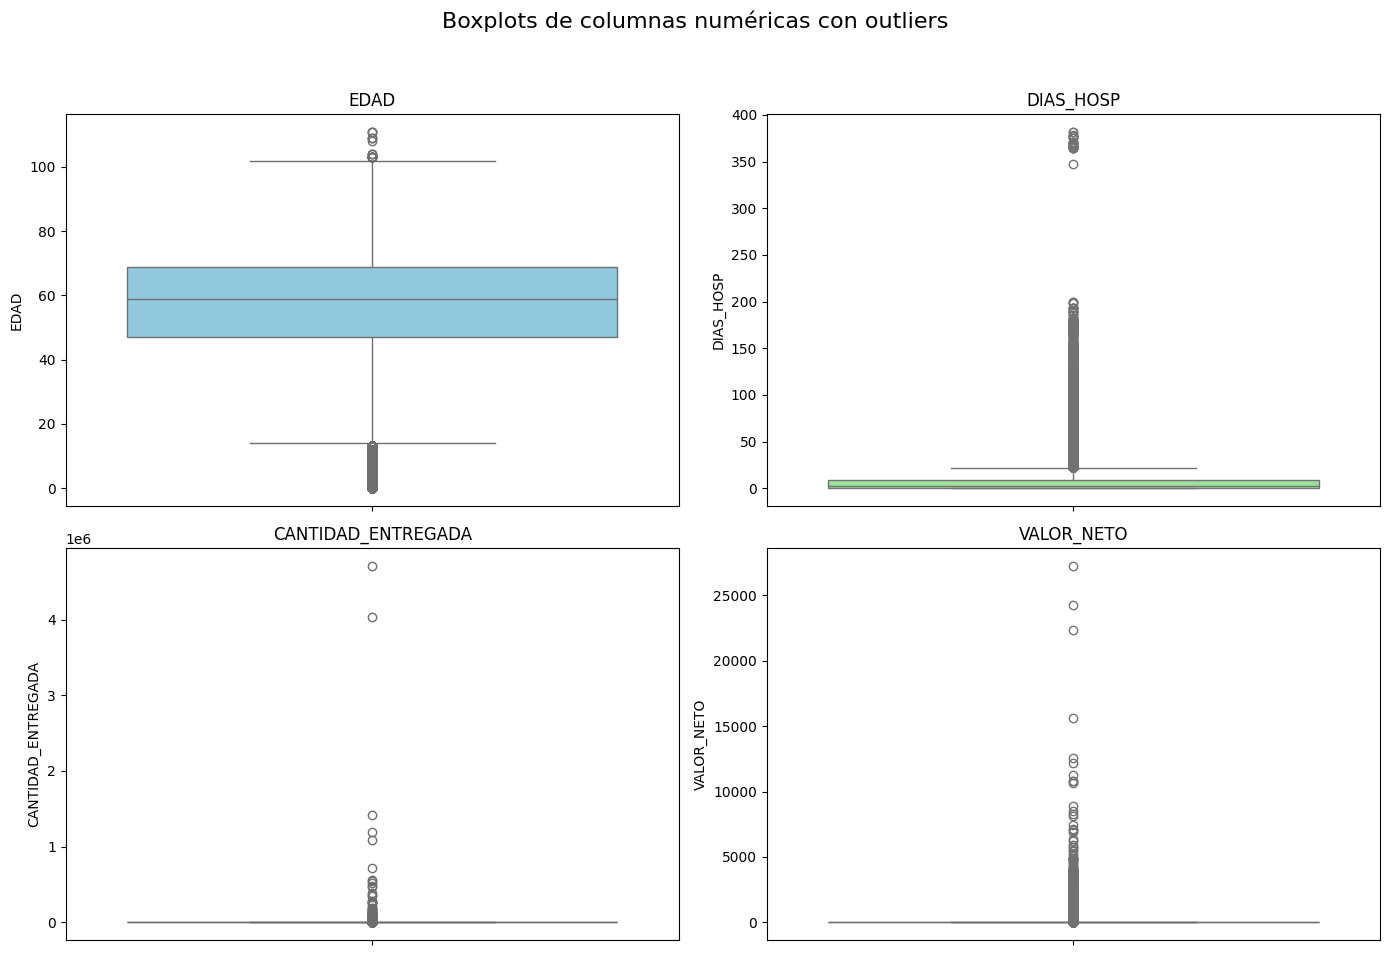

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sample_df = df.select("EDAD", "DIAS_HOSP", "CANTIDAD_ENTREGADA", "VALOR_NETO").sample(fraction=0.01, seed=42)
pdf = sample_df.toPandas()

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Boxplots de columnas numéricas con outliers", fontsize=16)

sns.boxplot(y=pdf["EDAD"], ax=axs[0,0], color="skyblue")
axs[0,0].set_title("EDAD")

sns.boxplot(y=pdf["DIAS_HOSP"], ax=axs[0,1], color="lightgreen")
axs[0,1].set_title("DIAS_HOSP")

sns.boxplot(y=pdf["CANTIDAD_ENTREGADA"], ax=axs[1,0], color="lightcoral")
axs[1,0].set_title("CANTIDAD_ENTREGADA")

sns.boxplot(y=pdf["VALOR_NETO"], ax=axs[1,1], color="khaki")
axs[1,1].set_title("VALOR_NETO")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [31]:
# Ver si ante una mayor CANTIDAD_ENTREGADA o VALOR_NETO la otra variable también incrementa
display(df.filter(
    (col("CANTIDAD_ENTREGADA") > 10000) | (col("VALOR_NETO") > 5000)
).select(
    "CANTIDAD_ENTREGADA", "VALOR_NETO", "NOMBRE_CONSUMO", "DEPARTAMENTO", "PROVINCIA", "FECHA_ATENCION"
))


DataFrame[CANTIDAD_ENTREGADA: int, VALOR_NETO: double, NOMBRE_CONSUMO: string, DEPARTAMENTO: string, PROVINCIA: string, FECHA_ATENCION: timestamp]

### Consolidado

## EDA

In [8]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming your original DataFrame is called 'df'

# 1. Select relevant columns that actually exist in your DataFrame
df_personas = df.select(
    'CODIGO_ANONIMIZADO',
    'SEXO',
    'EDAD',
    'FECHA_NACIMIENTO',
    'FECHA_FALLECIMIENTO',
    'UBIGEO',
    'DEPARTAMENTO',
    'PROVINCIA',
    'DISTRITO',
    'TIPO_DIABETES',
    'NIVEL_EESS',
    'DIAS_HOSP',
    'FECHA_ATENCION',
    'TIPO_PERSONAL_SALUD',
    'CODIGO_CONSUMO',
    'NOMBRE_CONSUMO',
    'CANTIDAD_ENTREGADA',
    'VALOR_NETO'
).distinct()

# 2. Calculate max age and other windowed calculations
window_spec = Window.partitionBy('CODIGO_ANONIMIZADO')

df_personas = df_personas.withColumn('EDAD_MAX', F.max('EDAD').over(window_spec)) \
    .withColumn('TOTAL_DIAS_HOSP', F.sum('DIAS_HOSP').over(window_spec)) \
    .withColumn('TOTAL_VALOR_NETO', F.sum('VALOR_NETO').over(window_spec)) \
    .withColumn('COUNT_ATENCIONES', F.count('FECHA_ATENCION').over(window_spec)) \
    .withColumn('LAST_FECHA_ATENCION', F.max('FECHA_ATENCION').over(window_spec))

# 3. Determine deceased status and other binary flags
df_personas = df_personas.withColumn('FALLECIDO', F.when(F.col('FECHA_FALLECIMIENTO').isNotNull(), 1).otherwise(0)) \
    .withColumn('TIENE_DIABETES', F.when(F.col('TIPO_DIABETES').isNotNull(), 1).otherwise(0)) \
    .withColumn('TIENE_HOSPITALIZACION', F.when(F.col('DIAS_HOSP') > 0, 1).otherwise(0))

# 4. Get most common diabetes type and consumption for each person
df_diabetes_type = df.filter(F.col('TIPO_DIABETES').isNotNull()) \
    .groupBy('CODIGO_ANONIMIZADO', 'TIPO_DIABETES') \
    .count() \
    .withColumn('rank', F.rank().over(Window.partitionBy('CODIGO_ANONIMIZADO').orderBy(F.desc('count')))) \
    .filter(F.col('rank') == 1) \
    .select('CODIGO_ANONIMIZADO', F.col('TIPO_DIABETES').alias('TIPO_DIABETES_PRINCIPAL'))

df_top_med = df.filter(F.col('CODIGO_CONSUMO').isNotNull()) \
    .groupBy('CODIGO_ANONIMIZADO', 'CODIGO_CONSUMO', 'NOMBRE_CONSUMO') \
    .agg(F.sum('CANTIDAD_ENTREGADA').alias('TOTAL_CANTIDAD')) \
    .withColumn('rank', F.rank().over(Window.partitionBy('CODIGO_ANONIMIZADO').orderBy(F.desc('TOTAL_CANTIDAD')))) \
    .filter(F.col('rank') == 1) \
    .select('CODIGO_ANONIMIZADO', 
            F.col('CODIGO_CONSUMO').alias('PRINCIPAL_CODIGO_CONSUMO'),
            F.col('NOMBRE_CONSUMO').alias('PRINCIPAL_NOMBRE_CONSUMO'))

# 5. Create the final consolidated DataFrame
df_consolidado = df_personas.groupBy('CODIGO_ANONIMIZADO').agg(
    F.first('SEXO').alias('SEXO'),
    F.max('EDAD_MAX').alias('EDAD'),
    F.first('FECHA_NACIMIENTO').alias('FECHA_NACIMIENTO'),
    F.max('FALLECIDO').alias('FALLECIDO'),
    F.first('FECHA_FALLECIMIENTO').alias('FECHA_FALLECIMIENTO'),
    F.first('UBIGEO').alias('UBIGEO'),
    F.first('DEPARTAMENTO').alias('DEPARTAMENTO'),
    F.first('PROVINCIA').alias('PROVINCIA'),
    F.first('DISTRITO').alias('DISTRITO'),
    F.max('TIENE_DIABETES').alias('TIENE_DIABETES'),
    F.sum('TOTAL_DIAS_HOSP').alias('TOTAL_DIAS_HOSPITALIZACION'),
    F.max('TOTAL_VALOR_NETO').alias('TOTAL_GASTO_MEDICAMENTOS'),
    F.max('COUNT_ATENCIONES').alias('TOTAL_ATENCIONES'),
    F.max('LAST_FECHA_ATENCION').alias('ULTIMA_ATENCION'),
    F.first('NIVEL_EESS').alias('NIVEL_ESTABLECIMIENTO_PRINCIPAL'),
    F.max('TIENE_HOSPITALIZACION').alias('HOSPITALIZADO_ALGUNA_VEZ')
)

# 6. Join with diabetes type and top medication
df_consolidado = df_consolidado.join(df_diabetes_type, 'CODIGO_ANONIMIZADO', 'left') \
    .join(df_top_med, 'CODIGO_ANONIMIZADO', 'left')

# 7. Optional: Order by anonymized code
df_consolidado = df_consolidado.orderBy('CODIGO_ANONIMIZADO')

# Show schema and sample rows
df_consolidado.printSchema()

root
 |-- CODIGO_ANONIMIZADO: string (nullable = true)
 |-- SEXO: string (nullable = true)
 |-- EDAD: integer (nullable = true)
 |-- FECHA_NACIMIENTO: integer (nullable = true)
 |-- FALLECIDO: integer (nullable = true)
 |-- FECHA_FALLECIMIENTO: integer (nullable = true)
 |-- UBIGEO: integer (nullable = true)
 |-- DEPARTAMENTO: string (nullable = true)
 |-- PROVINCIA: string (nullable = true)
 |-- DISTRITO: string (nullable = true)
 |-- TIENE_DIABETES: integer (nullable = true)
 |-- TOTAL_DIAS_HOSPITALIZACION: long (nullable = true)
 |-- TOTAL_GASTO_MEDICAMENTOS: double (nullable = true)
 |-- TOTAL_ATENCIONES: long (nullable = true)
 |-- ULTIMA_ATENCION: integer (nullable = true)
 |-- NIVEL_ESTABLECIMIENTO_PRINCIPAL: integer (nullable = true)
 |-- HOSPITALIZADO_ALGUNA_VEZ: integer (nullable = true)
 |-- TIPO_DIABETES_PRINCIPAL: string (nullable = true)
 |-- PRINCIPAL_CODIGO_CONSUMO: string (nullable = true)
 |-- PRINCIPAL_NOMBRE_CONSUMO: string (nullable = true)



In [9]:
num_rows = df_consolidado.count()
num_cols = len(df_consolidado.columns)
print(f"Shape: ({num_rows}, {num_cols})")


Shape: (766547, 20)


In [ ]:
df_consolidado.take(10)

In [ ]:
df_consolidado.selectExpr(
    "count(*) as total_rows",
    "avg(EDAD) as edad_promedio",
    "min(EDAD) as edad_min",
    "max(EDAD) as edad_max",
    "approx_percentile(EDAD, array(0.25, 0.5, 0.75)) as edad_percentiles"
).show()


In [ ]:
from pyspark.sql.functions import col

# Columnas categóricas o binarias (string, integer con pocos valores únicos, etc.)
categorical_columns = [
    "SEXO",
    "TIENE_DIABETES",
    "FALLECIDO",
    "HOSPITALIZADO_ALGUNA_VEZ",
    "DEPARTAMENTO",
    "PROVINCIA",
    "DISTRITO",
    "TIPO_DIABETES_PRINCIPAL",
    "PRINCIPAL_CODIGO_CONSUMO",
    "PRINCIPAL_NOMBRE_CONSUMO",
    "NIVEL_ESTABLECIMIENTO_PRINCIPAL",
]

# Mostrar distribución de cada variable categórica
for col_name in categorical_columns:
    print(f"\n🔹 Distribución de: {col_name}")
    df_consolidado.groupBy(col_name).count().orderBy("count", ascending=False).show(10, truncate=False)


In [ ]:
from pyspark.sql.types import IntegerType, DoubleType
import matplotlib.pyplot as plt
import seaborn as sns

# Columnas numéricas adicionales relevantes
numeric_cols = [
    "EDAD",
    "FALLECIDO",
    "TOTAL_DIAS_HOSPITALIZACION",
    "TOTAL_GASTO_MEDICAMENTOS",
    "TOTAL_ATENCIONES",
    "NIVEL_ESTABLECIMIENTO_PRINCIPAL",
    "TIENE_DIABETES",
    "HOSPITALIZADO_ALGUNA_VEZ",
]

# Convertir a Pandas para graficar
df_pd = df_consolidado.select(numeric_cols).dropna().toPandas()

# Graficar cada columna numérica
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    
    # Discretas: usar countplot si valores únicos < 10
    if df_pd[col].nunique() < 10 and df_pd[col].dtype in [int, 'int64']:
        sns.countplot(data=df_pd, x=col, palette='Set2')
        plt.ylabel("Frecuencia")
    else:
        sns.histplot(df_pd[col], bins=30, kde=True, color='skyblue')
        plt.ylabel("Frecuencia")
    
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Agrupar y contar
counts_df = (
    df_consolidado.groupBy("TIPO_DIABETES_PRINCIPAL")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

# Convertir a Pandas
counts_pd = counts_df.toPandas().dropna()
counts_pd["percentage"] = (counts_pd["count"] / counts_pd["count"].sum()) * 100

# Gráfico circular
plt.figure(figsize=(6, 6))
plt.pie(
    counts_pd["count"],
    labels=[f"{cat} ({pct:.1f}%)" for cat, pct in zip(counts_pd["TIPO_DIABETES_PRINCIPAL"], counts_pd["percentage"])],
    colors=plt.cm.Pastel1.colors,
    startangle=140,
    autopct=lambda pct: f"{pct:.1f}%" if pct > 2 else '',
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribución de TIPO_DIABETES_PRINCIPAL")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
# Agrupar y contar los tipos de diabetes principales
counts_df = (
    df_consolidado.groupBy("TIPO_DIABETES_PRINCIPAL")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
)

# Convertir a Pandas y calcular porcentajes
counts_pd = counts_df.toPandas().dropna()
counts_pd["percentage"] = (counts_pd["count"] / counts_pd["count"].sum()) * 100

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(
    counts_pd["TIPO_DIABETES_PRINCIPAL"].astype(str),
    counts_pd["count"],
    color=plt.cm.Pastel1.colors
)
plt.xlabel("Cantidad")
plt.ylabel("TIPO_DIABETES_PRINCIPAL")
plt.title("Top 10 categorías en TIPO_DIABETES_PRINCIPAL")

# Anotar cada barra con valor y porcentaje
for index, value in enumerate(counts_pd["count"]):
    plt.text(value, index, f"{value} ({counts_pd['percentage'].iloc[index]:.1f}%)", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


##### Análisis bivariado

In [ ]:
from pyspark.sql.functions import col, year, to_date, when, lpad

# Asumimos que FECHA_NACIMIENTO es un entero tipo yyyymmdd
# Lo convertimos primero a string, luego a fecha
df_consolidado = df_consolidado.withColumn("FECHA_NACIMIENTO_STR", lpad(col("FECHA_NACIMIENTO").cast("string"), 8, "0"))
df_consolidado = df_consolidado.withColumn("FECHA_NACIMIENTO_DATE", to_date(col("FECHA_NACIMIENTO_STR"), "yyyyMMdd"))

# Derivar el año de nacimiento
df_consolidado = df_consolidado.withColumn("ANIO_NAC", year("FECHA_NACIMIENTO_DATE"))

# Clasificar grupo etario según edad
df_consolidado = df_consolidado.withColumn(
    "GRUPO_ETARIO",
    when(col("EDAD") < 18, "Menor de edad")
    .when((col("EDAD") >= 18) & (col("EDAD") <= 39), "Joven-adulto")
    .when((col("EDAD") >= 40) & (col("EDAD") <= 64), "Adulto")
    .otherwise("Adulto mayor")
)


In [ ]:
df_consolidado.groupBy("SEXO", "GRUPO_ETARIO") \
    .count() \
    .orderBy("SEXO", "GRUPO_ETARIO") \
    .show()


In [ ]:
df_consolidado.groupBy("TIPO_DIABETES_PRINCIPAL", "GRUPO_ETARIO") \
    .count() \
    .orderBy("TIPO_DIABETES_PRINCIPAL", "GRUPO_ETARIO") \
    .show()


In [ ]:
df.groupBy("NIVEL_EESS", "GRUPO_ETARIO").count().orderBy("NIVEL_EESS", "GRUPO_ETARIO").show()


In [ ]:
df_consolidado.groupBy("DEPARTAMENTO") \
    .avg("EDAD") \
    .orderBy("avg(EDAD)", ascending=False) \
    .show()


In [ ]:
df.groupBy("GRUPO_ETARIO").agg(
    {"CANTIDAD_ENTREGADA": "avg", "VALOR_NETO": "avg"}
).withColumnRenamed("avg(CANTIDAD_ENTREGADA)", "PROM_CANTIDAD") \
 .withColumnRenamed("avg(VALOR_NETO)", "PROM_VALOR") \
 .orderBy("GRUPO_ETARIO") \
 .show()


In [ ]:
from pyspark.sql.functions import col

df_consolidado.filter(col("FECHA_FALLECIMIENTO").isNotNull()).count()


In [ ]:
from pyspark.sql.functions import to_date, col, lpad

# Asegurar que la fecha tenga 8 dígitos, convertir a string y luego a tipo fecha
df_consolidado = df_consolidado.withColumn(
    "FECHA_FALLECIMIENTO_STR", lpad(col("FECHA_FALLECIMIENTO").cast("string"), 8, "0")
)

df_consolidado = df_consolidado.withColumn(
    "FECHA_FALLECIMIENTO_DATE", to_date(col("FECHA_FALLECIMIENTO_STR"), "yyyyMMdd")
)


In [ ]:
from pyspark.sql.functions import when, col

# Crear columna binaria FALLECIDO (1 si tiene fecha de fallecimiento, 0 si no)
df_consolidado = df_consolidado.withColumn(
    "FALLECIDO",
    when(col("FECHA_FALLECIMIENTO").isNotNull(), 1).otherwise(0)
)


In [ ]:
from pyspark.sql.functions import col

df_consolidado.filter(col("FECHA_FALLECIMIENTO").isNotNull()).count()


In [ ]:
from pyspark.sql.functions import when, col

df_consolidado = df_consolidado.withColumn(
    "GRUPO_EDAD", 
    when(col("EDAD") < 18, "0-17")
    .when((col("EDAD") >= 18) & (col("EDAD") <= 40), "18-40")
    .when((col("EDAD") > 40) & (col("EDAD") <= 60), "41-60")
    .when((col("EDAD") > 60) & (col("EDAD") <= 80), "61-80")
    .otherwise("80+")
)


In [ ]:
df_consolidado.groupBy("SEXO") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .show()


In [ ]:
import matplotlib.pyplot as plt

# Ejemplo: Mortalidad por sexo
sexo_df = df_consolidado.groupBy("SEXO") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .toPandas()

# Gráfico de barras
sexo_df.plot(kind='bar', x='SEXO', y='TASA_MORTALIDAD', legend=False, color='skyblue')
plt.ylabel("Tasa de Mortalidad")
plt.title("Mortalidad por Sexo")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
df_consolidado.groupBy("TIPO_DIABETES_PRINCIPAL") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .show()


In [ ]:
import matplotlib.pyplot as plt

# Calcular tasa de mortalidad por tipo de diabetes
diabetes_df = df_consolidado.groupBy("TIPO_DIABETES_PRINCIPAL") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .toPandas()

# Gráfico de barras
diabetes_df.plot(kind='bar', x='TIPO_DIABETES_PRINCIPAL', y='TASA_MORTALIDAD', legend=False, color='salmon')
plt.ylabel("Tasa de Mortalidad")
plt.title("Mortalidad por Tipo de Diabetes")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
df_consolidado.groupBy("GRUPO_EDAD") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .show()


In [ ]:
import matplotlib.pyplot as plt

# Calcular tasa de mortalidad por grupo etario
edad_df = df_consolidado.groupBy("GRUPO_EDAD") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .toPandas() \
    .sort_values(by="GRUPO_EDAD")

# Gráfico de barras
edad_df.plot(kind='bar', x='GRUPO_EDAD', y='TASA_MORTALIDAD', legend=False, color='cornflowerblue')
plt.ylabel("Tasa de Mortalidad")
plt.title("Mortalidad por Grupo Etario")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
df_consolidado.groupBy("DEPARTAMENTO") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .orderBy("TASA_MORTALIDAD", ascending=False) \
    .show(10)


In [ ]:
import matplotlib.pyplot as plt

# Calcular tasa de mortalidad por departamento
dept_df = df_consolidado.groupBy("DEPARTAMENTO") \
    .agg({"FALLECIDO": "avg"}) \
    .withColumnRenamed("avg(FALLECIDO)", "TASA_MORTALIDAD") \
    .toPandas() \
    .sort_values(by="TASA_MORTALIDAD", ascending=False)

# Gráfico de barras
dept_df.plot(kind='bar', x='DEPARTAMENTO', y='TASA_MORTALIDAD', legend=False, figsize=(12, 5), color='mediumpurple')
plt.ylabel("Tasa de Mortalidad")
plt.title("Mortalidad por Departamento")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
